# ML regression model as a surroage model

In [1]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from parameters import parameters as pm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

## Load data

* q_data: $q \in [0.1,5]^4$

* y_data: $\alpha^{v},\beta^{v},\alpha^{max},\beta^{max},\alpha^{min},\beta^{min}$ standardization

* train:test=9:1  

* 5-fold cross validation, at each training set, 20% is used for validation

In [2]:
df=pd.read_excel(pm.file_datasets,index_col=0)

In [3]:
df.columns

Index(['q1', 'q2', 'q3', 'q4', 'alpha_vol', 'beta_vol', 'alpha_max',
       'beta_max', 'alpha_min', 'beta_min'],
      dtype='object')

In [4]:
df.columns=['q1', 'q2', 'q3', 'q4', r'$\alpha^v$', r'$\beta^v$', r'$\alpha^1$',
       r'$\beta^1$', r'$\alpha^2$', r'$\beta^2$']

In [5]:
df.describe()

,q1,q2,q3,q4,$\alpha^v$,$\beta^v$,$\alpha^1$,$\beta^1$,$\alpha^2$,$\beta^2$
count,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,2.600700,2.600554,2.599693,2.599807,15.094456,1.092729,123.085574,1.331359,56.525405,1.226724
std,1.385338,1.385518,1.385785,1.385893,6.036963,0.150210,46.114824,0.171567,22.556580,0.183597
min,0.200084,0.200386,0.200090,0.200222,0.561585,0.976145,9.008910,1.003005,4.666916,1.000099
25%,1.401405,1.400876,1.399161,1.399617,10.678713,1.011990,93.677995,1.228542,41.438695,1.118608
50%,2.600653,2.600804,2.599831,2.599082,15.366682,1.031559,121.284121,1.274907,55.800434,1.155044
75%,3.800111,3.800463,3.799689,3.800125,19.484902,1.093286,150.709236,1.356900,70.234569,1.242047
max,4.999808,4.999766,4.999649,4.999584,29.369184,1.806483,452.741789,2.312083,193.279605,2.221449


In [6]:
df.head(5)

,q1,q2,q3,q4,$\alpha^v$,$\beta^v$,$\alpha^1$,$\beta^1$,$\alpha^2$,$\beta^2$
0,4.961442,2.385522,2.896893,0.806421,20.223655,1.103777,175.209895,1.278621,77.992722,1.198342
1,2.509299,3.074866,0.972012,4.125319,16.398545,0.999593,51.617745,1.003269,38.960331,1.001141
2,1.773326,0.717280,1.926991,1.375933,5.623686,1.187663,81.553839,1.502992,31.950368,1.412077
3,1.550003,0.337619,1.263067,3.412958,3.454852,1.438510,86.902361,1.806967,33.457987,1.777304
4,4.681192,1.154233,0.885567,4.695532,16.217840,1.255864,160.651447,1.373127,83.251062,1.351132


In [7]:
feature_columns=[ r'$\alpha^v$', r'$\beta^v$', r'$\alpha^1$',
       r'$\beta^1$', r'$\alpha^2$', r'$\beta^2$']
for col in feature_columns:
    df[col]=(df[col]-df[col].mean())/df[col].std()

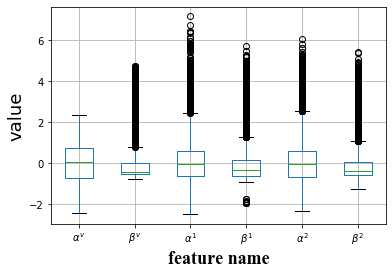

In [8]:
df[feature_columns].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

In [8]:
def box_plot_outliers(data_ser, box_scale):
    """
    remove some outliers
    :param data_ser: pandas.Series
    :param box_scale: the scale，
    :return:
    """
    iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
    val_low = data_ser.quantile(0.25) - iqr
    val_up = data_ser.quantile(0.75) + iqr
    low_index = data_ser[data_ser < val_low].index
    up_index = data_ser[data_ser > val_up].index

    return list(low_index) + list(up_index)

In [9]:
error_index = []
for col in feature_columns:
    error_index += box_plot_outliers(df[col],box_scale=3)
df=df.drop(error_index)

In [10]:
#print(len(error_index))
#data_ser = df[feature_columns[0]]
#box_scale = 3
#iqr =(data_ser.quantile(0.75) - data_ser.quantile(0.25))
# print(iqr)

In [11]:
q_data,y_data=df.iloc[:,:4],df.iloc[:,4:]

In [12]:
train_size=int(0.9*len(q_data))

In [13]:
q_data_train,q_data_test=q_data.iloc[:train_size,:],q_data.iloc[train_size:,:]
y_data_train,y_data_test=y_data.iloc[:train_size,:],y_data.iloc[train_size:,:]

###  experimental data

In [14]:
q_data_exp,y_data_exp=df.iloc[-1,:4].values.reshape((1,-1)),df.iloc[-1,4:].values.reshape((1,-1))

In [15]:
q_data_train.shape,q_data_test.shape,q_data_exp.shape,y_data_exp.shape

((8171, 4), (908, 4), (1, 4), (1, 6))

In [16]:
q_data_exp

array([[1., 1., 1., 1.]])

## Regression model
* [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=kneighborsregressor#)
* [xgboost](https://xgboost.readthedocs.io/en/latest/index.html)
* [muilt-layer perception](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlpregressor#)

##  Model trainning

* [Mulit-output regression model](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html?highlight=multioutputregressor#)  
This strategy consists of fitting one regressor per target. This is a simple strategy for extending regressors that do not natively support multi-target regression.
* [oof:](https://stackoverflow.com/questions/52396191/what-is-oof-approach-in-machine-learning)  
OOF simply stands for "Out-of-fold" and refers to a step in the learning process when using k-fold validation in which the predictions from each set of folds are grouped together into one group

In [17]:
# Class to extend the Sklearn regressor
class SklearnHelper(object):
    def __init__(self, clf, params=None,isMuilt_reg=False):
        if isMuilt_reg: self.clf= MultiOutputRegressor (clf(**params))
        else: self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def score(self,x,y):
        return self.clf.score(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [18]:
def mse_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))

X = q_data_train.values
y = y_data_train.values
X_test = q_data_test.values
y_test=y_data_test.values

In [19]:
X.shape,y.shape,X_test.shape,y_test.shape

((8171, 4), (8171, 6), (908, 4), (908, 6))

## Training the KNN model

In [20]:
fold = KFold(n_splits=5, shuffle=True, random_state=42)


def run_6sub_oof(clf, params):
    models = []
    pred = np.zeros(y_test.shape)
    oof = np.zeros(y.shape)
    for index, (train_idx, val_idx) in enumerate(fold.split(X)):
        x_tr, y_tr = X[train_idx,:], y[train_idx, :]
        x_val, y_val = X[val_idx,:], y[val_idx, :]

        tr_pred = np.zeros(y_tr.shape)
        val_pred = np.zeros(y_val.shape)
        test_pred = np.zeros(y_test.shape)
        for ix, para in enumerate (params):
            sub_model = clf(**para)
            sub_model.fit(x_tr, y_tr[:, ix])
            tr_pred[:, ix] = sub_model.predict(x_tr)
            val_pred[:, ix] = sub_model.predict(x_val)
            test_pred[:, ix] = sub_model.predict(X_test)
            models.append(sub_model) 
        oof[val_idx, :] = val_pred
        print('_'*100)
        print(index+1, 'Train: mse loss = {:.6f} r2_score = {:.6f}, Validation: mse loss = {:.6f} r2_score = {:.6f}'.format(
            mse_loss(y_tr, tr_pred), metrics.r2_score(y_tr, tr_pred),
            mse_loss(y_val, val_pred), metrics.r2_score(y_val, val_pred)))
        pred = pred+ test_pred/fold.n_splits
        del x_tr, y_tr, x_val, y_val
    print("#"*100)
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(
            mse_loss(y, oof),metrics.r2_score(y_test, pred)))
    return models,oof,pred

In [21]:
# setup the training for the knn model
knn_params=[]
grid_params ={
            'n_neighbors': [1, 2, 4, 6, 8, 10, 12, 14],
            'p': [1, 2],
            'algorithm': ['ball_tree'],
            'weights': ['distance'],
            'metric': ['minkowski'],
            'n_jobs': [-1]
        }
knn_sub = GridSearchCV(KNeighborsRegressor(), grid_params, scoring = 'r2', n_jobs = -1, cv = 5)

In [22]:
## training the KNN model
for feat_flag in range(len(feature_columns)):
   print('GridSearch for feature %d' % feat_flag)
   knn_sub.fit(X, y[:, feat_flag])
   print(knn_sub.best_params_)
   knn_params.append(knn_sub.best_params_)
    

GridSearch for feature 0
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
GridSearch for feature 1
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
GridSearch for feature 2
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 12, 'p': 2, 'weights': 'distance'}
GridSearch for feature 3
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
GridSearch for feature 4
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
GridSearch for feature 5
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}


In [23]:
# predicting the output and others using the selected hyperparameters
for feat_flag in range(len(feature_columns)):
    print('fitting feature %d' % feat_flag)
    knn_sub = KNeighborsRegressor(**knn_params[feat_flag])
    knn_sub.fit(X, y[:, feat_flag])
    pred = knn_sub.predict(X_test)
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

fitting feature 0
Test: mse loss=0.005265 r2_score=0.994493
fitting feature 1
Test: mse loss=0.015103 r2_score=0.938423
fitting feature 2
Test: mse loss=0.008760 r2_score=0.984925
fitting feature 3
Test: mse loss=0.028820 r2_score=0.901144
fitting feature 4
Test: mse loss=0.007684 r2_score=0.987512
fitting feature 5
Test: mse loss=0.026195 r2_score=0.910336


In [24]:
## now we will re-train the knn model using 5-fold cross-validation
knn_models, knn_oof, knn_pred = run_6sub_oof(KNeighborsRegressor, knn_params)
joblib.dump(knn_models, "./Results/knn_models.m")

## load the model 
knn_models = joblib.load("./Results/knn_models.m")

____________________________________________________________________________________________________
1 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.010406 r2_score = 0.963950
____________________________________________________________________________________________________
2 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.012491 r2_score = 0.957620
____________________________________________________________________________________________________
3 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.013664 r2_score = 0.955111
____________________________________________________________________________________________________
4 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.009149 r2_score = 0.967172
____________________________________________________________________________________________________
5 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.009186 r2_sc

## Training the xgboost model

In [25]:
###### training the xgboost model
xgboost_params = []
grid_params = {
            'n_estimators' : [500, 1000, 2000],
            'max_depth' : [1, 2, 4, 6, 8, 16],
            'learning_rate' : [0.05, 0.1, 0.2],
            'objective' : ['reg:squarederror'],
            'booster' : ['gbtree'],
            'n_jobs' : [-1]
   }
xgboost_sub = GridSearchCV(XGBRegressor(), grid_params, scoring = 'r2', n_jobs = -1, cv = 5)

In [26]:
for feat_flag in range(len(feature_columns)):
    print('GridSearch for feature %d' % feat_flag)
    xgboost_sub.fit(X, y[:, feat_flag])
    print(xgboost_sub.best_params_)
    xgboost_params.append(xgboost_sub.best_params_)

GridSearch for feature 0
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 1
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 2
{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 3
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 4
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 5
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}


In [27]:
# predicting the output and others using the selected hyperparameters
for feat_flag in range(len(feature_columns)):
    print('fitting feature %d' % feat_flag)
    xgboost_sub = XGBRegressor(**xgboost_params[feat_flag])
    xgboost_sub.fit(X, y[:, feat_flag])
    pred = xgboost_sub.predict(X_test)
    print('XGBoost Test: mse loss={:.6f} r2_score={:.6f}'.format(
            mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

fitting feature 0
XGBoost Test: mse loss=0.000302 r2_score=0.999684
fitting feature 1
XGBoost Test: mse loss=0.000515 r2_score=0.997901
fitting feature 2
XGBoost Test: mse loss=0.005981 r2_score=0.989708
fitting feature 3
XGBoost Test: mse loss=0.016798 r2_score=0.942380
fitting feature 4
XGBoost Test: mse loss=0.001816 r2_score=0.997049
fitting feature 5
XGBoost Test: mse loss=0.010354 r2_score=0.964558


In [29]:
## now we will re-train the xgboost model using 5-fold cross-validation
xgboost_models, xgboost_oof, xgboost_pred = run_6sub_oof(XGBRegressor, xgboost_params)
joblib.dump(xgboost_models, "./Results/xgboost_models.m")

## load the model 
xgboost_models = joblib.load("./Results/xgboost_models.m")

____________________________________________________________________________________________________
1 Train: mse loss = 0.000040 r2_score = 0.999884, Validation: mse loss = 0.001020 r2_score = 0.996825
____________________________________________________________________________________________________
2 Train: mse loss = 0.000037 r2_score = 0.999891, Validation: mse loss = 0.002481 r2_score = 0.992483
____________________________________________________________________________________________________
3 Train: mse loss = 0.000038 r2_score = 0.999889, Validation: mse loss = 0.002281 r2_score = 0.993423
____________________________________________________________________________________________________
4 Train: mse loss = 0.000042 r2_score = 0.999875, Validation: mse loss = 0.001723 r2_score = 0.995090
____________________________________________________________________________________________________
5 Train: mse loss = 0.000042 r2_score = 0.999879, Validation: mse loss = 0.000793 r2_sc

## training the MLP model

In [30]:
###training the MLP
mlp_params=[]
grid_params = {
            'hidden_layer_sizes' : [(128), (256,),(512,),(1024,)],
            'learning_rate_init' : [5e-3, 1e-2, 5e-2, 1e-3],
            'activation' : ['relu'],
            'early_stopping' : [True],
            'tol' : [1e-4],
            'n_iter_no_change' : [10],
            'max_iter' : [200]
    }

In [31]:
mlp_sub = GridSearchCV(MLPRegressor(), grid_params, scoring = 'r2', n_jobs = -1, cv = 5)
for feat_flag in range(len(feature_columns)):
    print('GridSearch for feature %d' % feat_flag)
    mlp_sub.fit(X, y[:, feat_flag])
    print(mlp_sub.best_params_)
    mlp_params.append(mlp_sub.best_params_)

GridSearch for feature 0
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (1024,), 'learning_rate_init': 0.01, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 1
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (1024,), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 2
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (1024,), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 3
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (512,), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 4
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (1024,), 'learning_rate_init': 0.005, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 5
{'activation': 'relu', 'early_stoppin

In [33]:
# predicting the output and others using the selected hyperparameters
for feat_flag in range(len(feature_columns)):
    print('fitting feature %d' % feat_flag)
    mlp_sub = MLPRegressor(**mlp_params[feat_flag])
    mlp_sub.fit(X, y[:, feat_flag])
    pred = mlp_sub.predict(X_test)
    print('MLP Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

fitting feature 0
MLP Test: mse loss=0.000222 r2_score=0.999768
fitting feature 1
MLP Test: mse loss=0.000460 r2_score=0.998126
fitting feature 2
MLP Test: mse loss=0.005301 r2_score=0.990878
fitting feature 3
MLP Test: mse loss=0.017978 r2_score=0.938333
fitting feature 4
MLP Test: mse loss=0.001543 r2_score=0.997492
fitting feature 5
MLP Test: mse loss=0.009774 r2_score=0.966543


In [34]:
## now we will re-train the mlp model using 5-fold cross-validation
mlp_models, mlp_oof, mlp_pred = run_6sub_oof(MLPRegressor, mlp_params)
joblib.dump(mlp_models, "./Results/mlp_models.m")

## load the model 
mlp_models = joblib.load("./Results/mlp_models.m")

____________________________________________________________________________________________________
1 Train: mse loss = 0.001388 r2_score = 0.995969, Validation: mse loss = 0.000841 r2_score = 0.997428
____________________________________________________________________________________________________
2 Train: mse loss = 0.001068 r2_score = 0.996856, Validation: mse loss = 0.002340 r2_score = 0.992820
____________________________________________________________________________________________________
3 Train: mse loss = 0.001047 r2_score = 0.996958, Validation: mse loss = 0.002042 r2_score = 0.994245
____________________________________________________________________________________________________
4 Train: mse loss = 0.001275 r2_score = 0.996172, Validation: mse loss = 0.001346 r2_score = 0.996349
____________________________________________________________________________________________________
5 Train: mse loss = 0.001629 r2_score = 0.995384, Validation: mse loss = 0.000450 r2_sc

## training the Gaussian process

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [37]:
## not yet finished
kernel = RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0))
# kernel = RBF(**gpr_para[feat_flag])

gpr_models=[]
for feat_flag in range(len(feature_columns)):
    gpr_sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_sub.fit(X, y[:, feat_flag])
    print(gpr_sub.kernel_)
    gpr_models.append(gpr_sub)


fitting feature 0
RBF(length_scale=0.702)
fitting feature 1
RBF(length_scale=0.645)
fitting feature 2
RBF(length_scale=0.538)
fitting feature 3
RBF(length_scale=0.521)
fitting feature 4
RBF(length_scale=0.589)
fitting feature 5
RBF(length_scale=0.572)


In [38]:
# predicting the output and others using the selected hyperparameters
for feat_flag in range(len(feature_columns)):
    print('fitting feature %d' % feat_flag)
    gpr_sub = gpr_models[feat_flag]
    pred = gpr_sub.predict(X_test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.001082 r2_score=0.998868
fitting feature 1
gpr Test: mse loss=0.002709 r2_score=0.988955
fitting feature 2
gpr Test: mse loss=0.018449 r2_score=0.968250
fitting feature 3
gpr Test: mse loss=0.035366 r2_score=0.878689
fitting feature 4
gpr Test: mse loss=0.007006 r2_score=0.988614
fitting feature 5
gpr Test: mse loss=0.019225 r2_score=0.934193


In [39]:
joblib.dump(gpr_models, "./Results/gpr_models.m")
## load the model 
gpr_models = joblib.load("./Results/gpr_models.m")

## following will be for optimization

To be updated 

### Model evaluation

* The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
* The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

## Load model

In [38]:
from sklearn.externals import joblib
models = joblib.load("./Results/knn_model.m")

In [44]:
def loss_func(x):
    # MSE 均方误差损失函数
    y_pre=np.zeros(y_data_exp.shape)
    for ix, model in enumerate(models):
        y_pre[:, ix % 6] += model.predict(x.reshape(1, -1))/5
    print(y_pre,y_data_exp)
    loss = mse_loss(y_pre, y_data_exp)
    return loss

# callback to save the function value.
def callback_save_func_val(xk, convergence):
    # xk is the current value of x0
    global niter
    niter=niter+1
    error=loss_func(xk)
    print('-'*100)
    print('niter={}:current x={},mse loss={}'.format(niter,xk,error))
    x_vec.append(xk)
    y_vec.append(error)
    return 

In [45]:
# experimental value test
loss=loss_func(q_data_exp)
print(loss)

[[-1.75607231 -0.39359753 -1.5791248   0.44261154 -1.63218512  0.37192332]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
0.037457370941375835


In [41]:
q_data_exp

array([[1., 1., 1., 1.]])

## optimation process

In [ ]:
from scipy.optimize import differential_evolution
import random
start_time=time.clock()
global niter#niter:Number of evaluations of the objective functions and of its Jacobian and Hessian.
niter=0
start_time=time.clock()

lb=0.2*q_data_exp[0]
ub=5*q_data_exp[0]
x0=(random.random()*(ub-lb)+lb)
print('initiate point x:',x0)
x_vec,y_vec=[],[]
res=differential_evolution(loss_func,bounds=[(lb[i],ub[i])for i in range(len(lb))]
            , strategy='best1bin', maxiter=500, popsize=50, tol=1e-6, mutation=(0.5, 1)
            , recombination=0.7,callback=callback_save_func_val)
end_time=time.clock()
print ('#'*100)
print(res)
print('optimation cost time=%f(s)' %(end_time-start_time))

initiate point x: [0.75098195 0.75098195 0.75098195 0.75098195]
[[-1.74469664 -0.22922579 -1.47788775  0.55478676 -1.55127962  0.37597663]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.21388128 -0.48983666 -0.66369976  0.08557371 -0.67500674 -0.24628228]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.58219319 -0.68785738 -1.59575004 -0.03321442 -1.55248104 -0.23072131]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.51944414 -0.08314959 -0.21634166 -0.13308243 -0.38350658 -0.17746907]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.12969407 -0.56588013 -0.50245576 -0.55628501 -0.45073981 -0.57382617]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.83332611 -0.63181245 -1.06753008 -0.10229622 -1.05530854 -0.35803988]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.69154794  0.4168966

[[-0.39125237 -0.17554184 -0.14351634 -0.03919448 -0.30091193 -0.09898462]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76591779 -0.42966687 -1.63832184  0.49760915 -1.6683974   0.2767869 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.56809458 -0.41170651  0.23523221 -0.62922895  0.17258561 -0.59758113]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.35154416 -0.14706142  0.47507252 -0.34246512  0.24558018 -0.32343856]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[0.02673397 0.85467796 0.68649518 0.23230658 0.8250101  0.60590844]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.75069996 -0.51952409 -0.83611355 -0.34606001 -0.78648313 -0.40912999]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.67368904 -0.46656425  0.22042474 -0.69696562  0.26063633 -0.64504579]] [[-1.68777667 -0.5

[[ 0.21692536 -0.60948623 -0.29306979 -0.69812583 -0.17725824 -0.71184772]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.22085086 -0.40619008 -0.3537816  -0.32526952 -0.35993223 -0.33939236]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.79582789 -0.47820268  0.9153757  -0.89972675  1.08380957 -0.77424578]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.91663839 -0.66752212 -1.18895118 -0.14830601 -1.06939474 -0.41327812]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.53409566 -0.42792016  0.19099584 -0.6434215   0.17937948 -0.61653132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[0.25619419 0.85109668 0.85182407 0.06189503 1.17953196 0.4746166 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.31399102 -0.22219509 -1.05863407  0.09454504 -1.16877206 -0.02813425]] [[-1.68777667 -0.5

[[ 1.81606519 -0.45281775  0.97617535 -0.85939727  1.06680921 -0.74037907]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.07721225 -0.54644301  0.15325738 -0.67856294  0.3119584  -0.67121911]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.91046925 -0.13405873  0.92465498 -0.47996182  0.75072813 -0.38308268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.37837574  0.63402628  0.34582156  0.35508663  0.31701352  0.55853872]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.58720682 -0.50955961 -0.28927024 -0.34845375 -0.14226382 -0.49296447]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.1488248  -0.23395612  1.00653449 -0.48373734  0.84362872 -0.41084274]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.76635581 -0.38948749  0.34229312 -0.52476854  0.35006116 -0.47196593]] [[-1.6877766

[[-0.09177822  1.22396054  0.65776005  0.40812895  0.96322115  0.87405625]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57587217 -0.72075142 -1.60799429  0.21443065 -1.55859441 -0.11839894]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.30915708 -0.43305664 -0.39677362 -0.44915804 -0.42896586 -0.51126541]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.08575623 -0.57802034 -0.45619765 -0.61662876 -0.40990632 -0.64761799]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.49260337 -0.52981769 -0.23439917 -0.40827896 -0.14382024 -0.50671301]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.44532973  0.02822086 -1.09924224  0.51954848 -1.23199624  0.44505858]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.71697347 -0.41748427  0.87974515 -0.77815376  0.98153878 -0.65888275]] [[-1.6877766

[[-1.94254123 -0.41309608 -1.80722449  0.87251629 -1.8241284   0.66156028]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.32047483 -0.56998283 -0.76679349 -0.11779475 -0.68683432 -0.3998112 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.28839264 -0.57512565 -0.79148897 -0.19129681 -0.69229109 -0.44055856]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.86570881 -0.47729596 -0.83222511 -0.30483779 -0.89859136 -0.39021111]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74796353  0.08334134 -1.50458377  0.93913382 -1.59677273  0.78794119]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.30918083 -0.43763546 -0.4771387  -0.16006622 -0.42964698 -0.2635978 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.25350364 -0.38520988 -0.3052487  -0.4494437  -0.39532113 -0.50561031]] [[-1.6877766

[[-0.75411628 -0.15184328 -0.50196001 -0.02475803 -0.63305711 -0.09842948]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.90764028  0.15965892 -0.45845462  0.21540226 -0.62948038  0.20581222]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.33068906 -0.62089967 -1.42309096 -0.05362343 -1.38944868 -0.18446473]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.36236871 -0.33870371 -1.21645201  0.10358571 -1.25910655 -0.08076876]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.2255951   1.05206136 -0.44112643  1.09036783 -0.57135955  1.18517636]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.60481018 -0.36013592  0.30973654 -0.59437562  0.26716541 -0.55071884]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.23171735 -0.5514273  -0.36806725 -0.53391477 -0.2695307  -0.54745035]] [[-1.6877766

[[-1.71855062 -0.2638256  -1.52497536  0.52366085 -1.57757123  0.35102313]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.19585364 -0.53463068 -1.12972983 -0.27867828 -1.13194204 -0.39657722]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.39168953 -0.70166155 -1.52147731  0.05705652 -1.39870646 -0.25982907]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.69368057 -0.47890105  0.82627487 -0.88313305  0.99162357 -0.7684521 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.88071418 -0.55055282  0.090327   -0.71751937  0.21556699 -0.68646393]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.72648409 -0.45844653 -0.23700941 -0.37332482 -0.16004603 -0.39180845]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.84610538  0.68678398 -0.19255771  0.46973795 -0.24781781  0.59565016]] [[-1.6877766

[[-1.00769617 -0.67521365 -1.10832533 -0.40492536 -1.07399324 -0.54733663]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.55974317 -0.45048387 -1.4621665   0.21457635 -1.51958526  0.00322635]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.28433007 -0.41508996 -0.42167069  0.11682207 -0.44960937 -0.20394762]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.17513928 -0.45337229 -1.08402273 -0.1480787  -1.11543176 -0.28785904]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.51769338 -0.18524343  0.53362229 -0.39880618  0.34490482 -0.37502794]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.67448578 -0.48100846 -0.76604034 -0.36796244 -0.8108504  -0.41339438]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.76175303 -0.51266508 -0.06451905 -0.58230607  0.04347863 -0.55768648]] [[-1.6877766

[[ 0.25692251  0.46370289  0.69363521 -0.13026079  0.66924375  0.1417841 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.17360526 -0.15035529  0.34692141 -0.32348559  0.09747254 -0.29105909]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.87516901 -0.65926297 -1.08095309 -0.14521685 -1.02533952 -0.41009981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.88964743 -0.28388279 -1.74694372  0.89359932 -1.7568042   0.66982677]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.39654126 -0.24916862 -0.23422981 -0.17293005 -0.40129369 -0.20458056]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.1035345  -0.69533903 -1.22423503 -0.17554449 -1.23757484 -0.37915426]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.07028685  0.10447688  0.48949125 -0.07807018  0.28636107  0.00239711]] [[-1.6877766

[[-1.54835116  0.29308983 -1.15195553  1.0616122  -1.3469937   0.94310533]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.81109833 -0.52925522  0.0248567  -0.65931081  0.14474355 -0.62312488]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.53595467 -0.5734207  -0.84202011 -0.10208533 -0.76421338 -0.37332892]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.5650728  -0.64141194 -0.91089538 -0.28124552 -0.81531967 -0.50354809]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.7706052  -0.28317107  0.63152666 -0.52744694  0.48114617 -0.47889408]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68086217  0.40740941 -1.13502497  1.03822392 -1.23235709  0.91474816]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.28076138 -0.72092082 -1.38306522 -0.13660155 -1.31888986 -0.39586842]] [[-1.6877766

[[-1.62707412 -0.4192956  -1.42117689  0.20013515 -1.46296724  0.04887313]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.33528184 -0.3754331  -0.31294681 -0.4385384  -0.43968494 -0.50027328]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.31114871 -0.38469091  0.74760641 -0.68531508  0.78005357 -0.57722367]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.31320764  1.06016089 -0.52021272  1.08778809 -0.62052069  1.18011647]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84029857 -0.10349361 -1.63178823  0.85955772 -1.6465686   0.69781784]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.29341808  1.16963445  0.49811378  0.48412717  0.63305086  0.84402434]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.2392643   0.46477802  0.35722807  0.04362482  0.29971777  0.23279532]] [[-1.6877766

[[-1.63510521 -0.40425944 -1.52155178  0.21495809 -1.53286783  0.06807159]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.11965927  0.78139456 -0.3789306   0.64314712 -0.49518929  0.78064162]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78674717 -0.59861741 -1.74645529  0.59333468 -1.75005786  0.26941281]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.90291358 -0.48344469 -1.79360586  0.94349173 -1.80066144  0.56503574]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.28194628  0.00867699 -0.93626372  0.24006893 -1.04648443  0.16622258]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.47662951 -0.68652501 -1.50536666 -0.11148068 -1.46988773 -0.30632896]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.92606251 -0.58820012 -1.87264795  0.72460828 -1.82861175  0.50534539]] [[-1.6877766

[[-1.70656765  0.46193423 -1.23715707  1.06095403 -1.34312616  1.01901908]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69206686 -0.46756738 -1.61790266  0.18936858 -1.56643002  0.07996715]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.30703119 -0.66063401 -1.32192041 -0.17857503 -1.36561956 -0.36788797]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.32353155 -0.30264993 -1.09295021  0.07321937 -1.1502766  -0.03566682]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.4130261  -0.63506403 -0.67182408 -0.58771057 -0.59004434 -0.65972023]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.21739252  0.19787608 -0.78252613  0.36618734 -0.96219823  0.31516668]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.13146243  0.8589356  -0.37132317  0.75148805 -0.48591661  0.85762587]] [[-1.6877766

[[-1.71169272 -0.62435452 -1.6967084   0.54353881 -1.70417766  0.25744185]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.43032804  0.34282775 -0.91015311  0.53991608 -1.06016331  0.56041615]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.37417059 -0.58049854 -1.43999105  0.34852363 -1.45277961  0.02932077]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.58997697 -0.47616191 -1.46347207  0.12345632 -1.46978058 -0.02387452]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.5199144  -0.68816864 -1.54455931  0.09233673 -1.45633555 -0.13600047]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76656057 -0.66578688 -1.77211248  0.61065618 -1.7572359   0.19873187]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.9293216  -0.58481102 -1.84445061  0.71832377 -1.80542113  0.43257792]] [[-1.6877766

[[-1.45798465 -0.36507662 -1.36180406  0.30144509 -1.4031009   0.20684936]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.45422495 -0.70908492 -1.57643399  0.1643943  -1.52559804 -0.19582579]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.82740912 -0.68367167 -1.08752806 -0.29556751 -0.96835186 -0.51146475]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.54487236  0.10787298 -1.15861595  0.65524468 -1.26878143  0.48708672]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77538443 -0.31946217 -1.57714508  0.53396665 -1.64241235  0.34518939]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61905754 -0.53378917 -1.52131612  0.16767481 -1.51781985 -0.06215039]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.76417992 -0.57031309 -0.00499349 -0.7277871   0.1380668  -0.70526332]] [[-1.6877766

[[-0.59179105 -0.43982016 -0.58678401 -0.39837055 -0.61431583 -0.45858262]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60522369 -0.24229631 -1.37959542  0.43829488 -1.40857251  0.255645  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.23968529  0.19773433 -0.71336977  0.47662541 -0.90772803  0.45320636]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67173689 -0.66143436 -1.700835    0.22906653 -1.64779292  0.05715179]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.99139156 -0.48769267 -1.91056747  0.96462819 -1.89826775  0.81134577]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72483502 -0.31865422 -1.62514192  0.67169305 -1.67926191  0.47631203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.07084968 -0.60358552 -1.22059708 -0.14984482 -1.19868313 -0.25896228]] [[-1.6877766

[[-1.98735648 -0.2492435  -1.85126966  1.3599883  -1.84225327  0.96229745]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84047012 -0.56956274 -1.75326618  0.44853056 -1.75070011  0.261954  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63365117  0.81141474 -1.05066317  1.25630561 -1.17314097  1.26380369]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.43816801 -0.5599474  -1.45837026  0.19428046 -1.40588946  0.02476365]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.84326284 -0.63519056 -0.97740363 -0.45803385 -0.92946413 -0.56170552]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73890364 -0.66474567 -1.73402216  0.55882112 -1.70712464  0.15112189]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74431468 -0.580722   -1.72432569  0.63000396 -1.72679482  0.39290116]] [[-1.6877766

[[ 0.39918093 -0.56097542 -0.28545433 -0.4951556  -0.21157854 -0.56264844]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.11017506 -0.40649918 -1.00580251  0.03585242 -1.05336216 -0.07986539]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84629589 -0.10713866 -1.61129421  0.94457777 -1.70570631  0.85134201]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.81628276 -0.63496958 -1.05298714 -0.04087038 -1.02684318 -0.36490624]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57775962 -0.60360186 -1.56586487 -0.03122071 -1.5006958  -0.16484315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.93682235 -0.08803226 -1.70193285  1.07598726 -1.71055491  0.88346405]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.63558873 -0.48399614 -0.26156105 -0.30197682 -0.09053952 -0.44965261]] [[-1.6877766

[[-1.34517815 -0.71242231 -1.42966184 -0.01417032 -1.37707631 -0.2747399 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.88775887 -0.57654805 -1.73520637  0.4842212  -1.72640807  0.28887096]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66130624  0.10880604 -1.32286785  0.83971    -1.4333273   0.73224464]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.42581932 -0.71783901 -1.46370028  0.01199336 -1.42572086 -0.21177789]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66896626  0.17942808 -1.24679204  0.6187069  -1.32577711  0.620831  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.93379382  0.21618345 -1.62643401  1.28600652 -1.67486724  1.19367121]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.12645521 -0.58345308 -0.65865577 -0.32145099 -0.52448197 -0.50472074]] [[-1.6877766

[[-1.68091893 -0.46832018 -1.55500387  0.23381034 -1.585931    0.10137643]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.32019489 -0.57313154 -1.30316312 -0.15721676 -1.30451667 -0.27527961]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.11548929 -0.71787928 -1.27200203 -0.33999038 -1.18074841 -0.50537638]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71254784 -0.68984555 -1.69902395  0.32347483 -1.66879031  0.05206061]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64888412 -0.30542083 -1.45879093  0.62854559 -1.55977909  0.40284107]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67326519  0.20281394 -1.2718783   0.85699833 -1.35054689  0.73548709]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.53305913 -0.72192294 -1.59220355  0.14913295 -1.54277055 -0.19758137]] [[-1.6877766

[[-1.7823183  -0.53704905 -1.64234762  0.32690881 -1.66750254  0.1481952 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61719762 -0.70725309 -1.63971012  0.0935648  -1.592785   -0.12205455]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.00529856 -0.65176941 -1.22094078 -0.10309954 -1.18700308 -0.31930375]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.14199447 -0.70086513 -1.26072195 -0.19115829 -1.23377712 -0.42656474]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57356079 -0.58941761 -1.6459349   0.65791481 -1.66175311  0.31076201]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.37215829 -0.66492043 -1.3831623  -0.12329498 -1.38681988 -0.31778778]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.6541703  -0.6450213  -0.94074622 -0.22779766 -0.87972623 -0.46998962]] [[-1.6877766

[[ 0.1436564  -0.53294857 -0.54274001 -0.28835105 -0.42611504 -0.44798163]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72663182 -0.30104376 -1.55472039  0.42502927 -1.59824849  0.32821139]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.5553828   0.0605115  -1.22852885  0.59317472 -1.28655489  0.44421438]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.37095106 -0.69808718 -1.46445892  0.06521376 -1.35793624 -0.26600137]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.43804449 -0.69895897 -1.49285768  0.20260311 -1.46855068 -0.17428802]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67794926 -0.26572184 -1.43447606  0.39717662 -1.47456185  0.24355397]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67561271 -0.59176217 -1.6198621   0.25491536 -1.56886382  0.08199952]] [[-1.6877766

[[-1.61876239 -0.69165402 -1.57216904 -0.02687734 -1.55446284 -0.19347245]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.83317772 -0.61334318 -1.74950012  0.53779782 -1.74418247  0.24543572]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.2891242  -0.54731671 -1.26354601 -0.07792604 -1.25722149 -0.20432524]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.88065981 -0.48014355 -1.78197893  0.66229196 -1.77167943  0.42567102]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70216084 -0.6470558  -1.71368057  0.34296375 -1.64186385  0.03783698]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.82815844 -0.60217892 -1.02906529 -0.3118457  -0.99581751 -0.39554865]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79801733 -0.44713701 -1.69730518  0.48008265 -1.70685939  0.32529351]] [[-1.6877766

[[-1.65826927 -0.52825786 -1.57088508  0.20389101 -1.56580507  0.01311179]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65503943 -0.654695   -1.65687114  0.16002164 -1.62391473 -0.06497531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.88984744 -0.42779779 -1.77269345  0.83363656 -1.76320328  0.56027447]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.53341801 -0.59600439 -1.50760615  0.04944288 -1.49923408 -0.05380065]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70997929 -0.3974502  -1.60286652  0.34792398 -1.59018504  0.24473999]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61493246 -0.64395949 -1.59311139  0.05561005 -1.56937996 -0.13797545]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68141463 -0.64244409 -1.6831      0.14770832 -1.65063396 -0.04133272]] [[-1.6877766

[[-1.79948155 -0.65729052 -1.75034697  0.33296965 -1.68949083  0.15106142]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.76041727 -0.53315623 -1.00901991  0.33855755 -1.06835085 -0.13271263]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.56143798 -0.63100736 -1.5629846   0.11763641 -1.49000734 -0.02367401]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57145022 -0.59450908 -1.52779902  0.02442154 -1.4733913  -0.10432347]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84578327 -0.55801778 -1.76848832  0.48404342 -1.74541707  0.31944595]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70372996 -0.67715969 -1.72004508 -0.02851296 -1.68045468 -0.10830854]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73705644 -0.49749533 -1.63532903  0.30856494 -1.60504455  0.18912779]] [[-1.6877766

[[-1.73424599 -0.30042337 -1.58219347  0.38070524 -1.60128047  0.27937342]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65347374 -0.30005989 -1.46593461  0.31633764 -1.45895168  0.17368102]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78828569 -0.3944641  -1.57662526  0.4398789  -1.60407009  0.29879919]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.5682128   0.42675962 -0.994556    0.8797899  -1.1070143   0.81827829]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75597888 -0.42779754 -1.61982251  0.19974962 -1.61630714  0.1410264 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.48812129  0.18691373 -1.05912598  0.55506657 -1.1882174   0.46515803]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69945186 -0.56295708 -1.63031734  0.16571151 -1.56925819  0.00486303]] [[-1.6877766

[[-1.75970056 -0.7164886  -1.73356593  0.15256426 -1.66581858 -0.04881173]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6951523  -0.65046909 -1.64699627  0.10090846 -1.60260425 -0.08516719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.90049344 -0.51315406 -1.82478315  0.75871023 -1.79777211  0.46353897]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.97663587 -0.4215721  -1.88584275  1.04652693 -1.88534441  0.85296076]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.46257907 -0.71293397 -1.48351815 -0.06203778 -1.41956457 -0.26601402]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72482912 -0.54798621 -1.69050295  0.64839743 -1.69229728  0.3521388 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.34977673 -0.70032601 -1.43688658 -0.03971458 -1.42168682 -0.23728489]] [[-1.6877766

[[-1.51015009 -0.2797708  -1.293778    0.28093718 -1.41014534  0.15461419]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.8257603  -0.66303637 -1.79542419  0.48012486 -1.73624427  0.19634524]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.90867234 -0.30539794 -1.78061244  0.97977295 -1.79279557  0.72894475]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78471077 -0.49918815 -1.69107274  0.39616063 -1.65672805  0.19638843]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64214383 -0.50579088 -1.49739577  0.15638848 -1.47372723 -0.0190777 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.33440702 -0.67502548 -1.39804924 -0.07876275 -1.38724209 -0.24370157]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79815091 -0.54071302 -1.69117049  0.4228823  -1.70437876  0.20746573]] [[-1.6877766

[[-1.77924334 -0.427072   -1.67946541  0.5121364  -1.67021318  0.31289866]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80232708 -0.33058112 -1.64661121  0.68340682 -1.68112324  0.4709563 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79729993 -0.53814282 -1.69026877  0.35709761 -1.71252888  0.16863786]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68614975 -0.36959755 -1.54250539  0.41893369 -1.57235953  0.18417748]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68076793 -0.49771684 -1.56205511  0.12286697 -1.56863179  0.01389546]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60581241 -0.43327754 -1.45136961  0.18225612 -1.42454387  0.03094699]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.89107781 -0.57122234 -1.82906994  0.75863327 -1.80353572  0.52112468]] [[-1.6877766

[[-1.52917835 -0.72956183 -1.5602627   0.01810898 -1.51778742 -0.17498307]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68499146 -0.59043613 -1.60442173  0.11361119 -1.60090473 -0.04107162]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71313613 -0.45499421 -1.63228666  0.33546353 -1.60849363  0.18150807]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60946642 -0.62744762 -1.57422382 -0.05955705 -1.49637556 -0.16223799]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6792857  -0.56625214 -1.67453163  0.1625005  -1.59617983  0.09780841]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64345114 -0.34987602 -1.49136085  0.24077927 -1.5243253   0.22070654]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66037808 -0.71265828 -1.66301913  0.13815008 -1.58845061 -0.10119923]] [[-1.6877766

[[-1.81231946 -0.44127444 -1.66198725  0.50261625 -1.61428961  0.29236926]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.83596969 -0.37883757 -1.68044537  0.62796228 -1.70458716  0.44152178]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73256304 -0.43691085 -1.54598157  0.31132943 -1.59184074  0.16862443]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.87729985 -0.39380529 -1.73376024  0.51773145 -1.69667049  0.49915622]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69672936 -0.46332013 -1.56616567  0.26080191 -1.581505    0.07640004]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66684819 -0.57260416 -1.5904445   0.11282226 -1.51627564 -0.06944425]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6615034  -0.53866807 -1.59298129  0.23740642 -1.5657346   0.10348347]] [[-1.6877766

[[-1.71535545 -0.40163762 -1.59717684  0.25867851 -1.60700158  0.16864615]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73639534 -0.65236309 -1.68189849  0.28725639 -1.70116065  0.08159051]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82566414 -0.36377929 -1.64525078  0.55046149 -1.69621892  0.38304597]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.41271959 -0.68406421 -1.46442725 -0.14815585 -1.43928943 -0.32272424]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81567199 -0.44095795 -1.66165973  0.3622262  -1.63777153  0.22805261]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77674069 -0.39258792 -1.63165547  0.36601273 -1.60672969  0.22583433]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65782453 -0.57686317 -1.54599375  0.131969   -1.5703102  -0.03707407]] [[-1.6877766

[[-1.51090535 -0.68454998 -1.52271082 -0.0511665  -1.49539478 -0.23087207]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71031596 -0.68963454 -1.69097834  0.16072186 -1.64997763 -0.03568108]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69959698 -0.47642344 -1.60134756  0.24906743 -1.59895435  0.11481812]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63477699 -0.58179712 -1.58419354  0.10802438 -1.56092835 -0.06065005]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71685429 -0.57781975 -1.62024348  0.20094329 -1.58108927  0.04298508]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7210229  -0.51334516 -1.62747973  0.26340606 -1.59323649  0.09149726]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.8016939  -0.67927471 -1.78748493  0.35315578 -1.7636071   0.13378725]] [[-1.6877766

[[-1.79680086 -0.63997452 -1.7562385   0.43536307 -1.73792504  0.17174326]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64635768 -0.64377867 -1.61677827  0.16875374 -1.60309409 -0.05959685]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73729047 -0.57743075 -1.67091097  0.2750638  -1.65369695  0.1023151 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.49277193 -0.70740085 -1.56310119  0.06118282 -1.53883479 -0.20018374]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82834069 -0.59185965 -1.77610789  0.51281742 -1.71911869  0.40236684]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7243562  -0.58397395 -1.63982622  0.2455023  -1.62155543  0.14721473]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69813639 -0.64179705 -1.67637477  0.13274865 -1.62428619 -0.06524444]] [[-1.6877766

[[-1.73415196 -0.42126237 -1.53752769  0.37154174 -1.6089198   0.26058625]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6656364  -0.29659291 -1.47114287  0.29320821 -1.49573358  0.20760999]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.83424845 -0.36454294 -1.70743893  0.513424   -1.69734319  0.48322246]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72830001 -0.5288018  -1.64486902  0.34068616 -1.62575727  0.18004531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6623747  -0.55792392 -1.60894448  0.32980929 -1.55747911  0.09753456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77577497 -0.36780181 -1.60778168  0.4406264  -1.62340525  0.2711167 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66881123 -0.26825669 -1.46376999  0.28715178 -1.43674447  0.2101266 ]] [[-1.6877766

[[-1.68644316 -0.58237592 -1.61384262  0.24438517 -1.59241346  0.03246155]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78774446 -0.53761025 -1.68522473  0.38998319 -1.69327207  0.20239902]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78557817 -0.64385133 -1.70287962  0.18148687 -1.67580479  0.00391631]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72103686 -0.51356132 -1.65869013  0.26884387 -1.63496946  0.18788962]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74645748 -0.54094249 -1.61591151  0.42710858 -1.58772845  0.15389203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70214827 -0.57808244 -1.62538169  0.20069576 -1.62447747  0.04143521]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68639302 -0.69972159 -1.69222666  0.21701594 -1.68392752  0.02008541]] [[-1.6877766

[[-1.76335623 -0.54947001 -1.72559393  0.42640216 -1.71119348  0.24078085]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72126342 -0.5260395  -1.62366889  0.35301619 -1.62917783  0.14796022]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63308955 -0.64854568 -1.59524155  0.11271269 -1.60283826 -0.08526956]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75976641 -0.54923773 -1.6629653   0.33627051 -1.61300721  0.15319654]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6783915  -0.29219466 -1.63346245  0.52124436 -1.6337911   0.32402653]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61330974 -0.52641036 -1.50612577  0.20072936 -1.5367121   0.09118179]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69611723 -0.30773405 -1.48456815  0.4988866  -1.51229356  0.29167484]] [[-1.6877766

[[-1.63173764 -0.66374564 -1.5953658   0.10833407 -1.58409031 -0.09832235]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61539077 -0.51862209 -1.53194266  0.19404095 -1.55360313 -0.0081121 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68054353 -0.6235136  -1.66657212  0.19935283 -1.60341214  0.04012889]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71463946 -0.16495378 -1.44273715  0.51613488 -1.47795025  0.41816067]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66635452 -0.6428155  -1.59902191  0.09078704 -1.58588112 -0.08508258]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84118482 -0.19261493 -1.64446751  0.80495979 -1.67172818  0.61124386]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77851043 -0.38984246 -1.58973457  0.42252489 -1.57256644  0.25345225]] [[-1.6877766

[[-1.72713213 -0.59009238 -1.69883748  0.23329556 -1.66850968  0.04633962]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.88041477 -0.42952362 -1.72650754  0.55919951 -1.72278562  0.43115125]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65890812 -0.56921361 -1.65405015  0.35591008 -1.6278846   0.15460333]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75868584 -0.65199649 -1.72806117  0.31162759 -1.6820476   0.05249396]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7271815  -0.52882592 -1.64825807  0.25235308 -1.64262069  0.09774234]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66998082 -0.69272432 -1.6464387   0.26352085 -1.62438816 -0.02060972]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.647647   -0.5566781  -1.6344235   0.36223289 -1.64115469  0.18766703]] [[-1.6877766

[[-1.67089026 -0.65451176 -1.62898663  0.10123437 -1.59449351 -0.10652624]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84519204 -0.7056817  -1.81562553  0.45277462 -1.76097809  0.19206495]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80882296 -0.64216176 -1.74561236  0.3287347  -1.72587351  0.12620828]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.56982921 -0.54911984 -1.55270253  0.08877424 -1.5009735  -0.09767598]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65453238 -0.38969926 -1.47350442  0.30452866 -1.52436677  0.14839499]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6380413  -0.55134999 -1.57441395  0.1994508  -1.54625142  0.00178785]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.829161   -0.66571665 -1.79036599  0.57057282 -1.78146921  0.25593156]] [[-1.6877766

[[-1.67142713 -0.53415269 -1.57183697  0.19898721 -1.58291569  0.01201347]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72423043 -0.68270641 -1.71438352  0.2030581  -1.66354661  0.04676354]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85239403 -0.57766897 -1.7660345   0.44472759 -1.7354118   0.22815625]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66548525 -0.56364789 -1.57677674  0.27334394 -1.57347516  0.03107191]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69228418 -0.56156673 -1.60680994  0.17416705 -1.59659512  0.01785243]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=10:current x=[0.85001421 0.98490977 3.94658948 1.94397735],mse loss=0.00011058640940459772
[[-1.823084   -0.39770197 -1.71713178  0.5

[[-1.69433607 -0.42810755 -1.6326512   0.56838836 -1.67201483  0.31432595]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.52468095 -0.53760325 -1.4431651   0.06358082 -1.43944259 -0.07426382]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76125687 -0.38974987 -1.606215    0.67279194 -1.62232688  0.57754835]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81817756 -0.59171235 -1.7815982   0.60672694 -1.77422207  0.31105017]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57035569 -0.55139044 -1.50435567  0.08288717 -1.51828367 -0.0917032 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61211179 -0.61785143 -1.56264374  0.03030742 -1.5188269  -0.05767027]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71254622 -0.46957126 -1.60877083  0.31809275 -1.61612241  0.13955364]] [[-1.6877766

[[-1.67767924 -0.54588055 -1.60269042  0.31859171 -1.58493986  0.09668618]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75290258 -0.63055086 -1.7428238   0.42587201 -1.73401319  0.2420208 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.53228994 -0.64476084 -1.50006936 -0.05491177 -1.45323998 -0.16616919]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71052514 -0.57035869 -1.67991034  0.21433519 -1.6252625   0.03845977]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73732488 -0.45845957 -1.64626516  0.51097427 -1.62516896  0.28842017]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7490439  -0.670349   -1.72621644  0.25908807 -1.72212876  0.06845625]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69820469 -0.50867345 -1.63615189  0.21452485 -1.60813717  0.07300718]] [[-1.6877766

[[-1.70138234 -0.60526588 -1.66855404  0.37354025 -1.6739425   0.16572409]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73399814 -0.57902027 -1.68225442  0.46882655 -1.70130673  0.28033214]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76721869 -0.62645735 -1.69368015  0.26774861 -1.66871744  0.07709265]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60214134 -0.66674755 -1.61883531  0.08346832 -1.58728599 -0.11269941]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69008689 -0.69681615 -1.71065647  0.30769928 -1.67832509  0.0176047 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67132666 -0.39748908 -1.50303686  0.25509043 -1.51807026  0.10388172]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7620205  -0.59272896 -1.66761305  0.24575193 -1.6680886   0.07338479]] [[-1.6877766

[[-1.75777467 -0.68555133 -1.72221003  0.28112324 -1.69458679  0.08514036]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72586645 -0.4926866  -1.60549075  0.18989608 -1.55084007  0.06030242]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68201796 -0.58939197 -1.60554001  0.19764835 -1.58598179  0.01606168]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67330419 -0.40993814 -1.524735    0.2231707  -1.55906585  0.10730661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66704257 -0.47407049 -1.57701091  0.27702398 -1.57365996  0.10855851]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59059492 -0.59227604 -1.53661511  0.12352707 -1.5342593  -0.10631505]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73850113 -0.61287321 -1.63321496  0.3479421  -1.62906643  0.06023319]] [[-1.6877766

[[-1.64619246 -0.67380152 -1.57403395  0.10495705 -1.53853393 -0.0966907 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69946155 -0.55801148 -1.63049544  0.25660348 -1.63027914  0.06562934]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69849745 -0.36990824 -1.59755049  0.49832077 -1.63073923  0.29022517]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70777847 -0.4968855  -1.63682259  0.36773956 -1.60987313  0.15139338]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61369224 -0.61645847 -1.57122783  0.02372883 -1.55668867 -0.04884382]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77902031 -0.25130313 -1.6086979   0.68626921 -1.64803872  0.55589043]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75669538 -0.59003595 -1.66616151  0.33889761 -1.65678085  0.16899287]] [[-1.6877766

[[-1.70228988 -0.48672674 -1.57010543  0.11915948 -1.53863499  0.06493737]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70780113 -0.63380641 -1.70220052  0.28052356 -1.6764483   0.09760766]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71110794 -0.6163334  -1.63045739  0.23369684 -1.62155869  0.05815466]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80595348 -0.46020076 -1.68025811  0.5302083  -1.68805999  0.38922449]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61843385 -0.59936732 -1.61311976  0.19108656 -1.55592557 -0.00940292]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7297883  -0.6444386  -1.63835159  0.14488658 -1.60888042 -0.01248611]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63560136 -0.58601693 -1.63188069  0.24443353 -1.59538409  0.03432954]] [[-1.6877766

[[-1.60140029 -0.45114138 -1.46398097  0.20291056 -1.45584783  0.07879719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74941079 -0.57757575 -1.70058574  0.34292513 -1.68773402  0.13594492]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71452029 -0.6567162  -1.71008029  0.3435729  -1.67363057  0.0949462 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.83059671 -0.48274518 -1.72915628  0.52615944 -1.68203619  0.40343819]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69571735 -0.54908123 -1.62270793  0.25239475 -1.64091256  0.02484878]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71474247 -0.39164131 -1.59676114  0.37170124 -1.61092348  0.21067105]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63833498 -0.57387509 -1.60310868  0.10325962 -1.54210407  0.02342793]] [[-1.6877766

[[-1.73140212 -0.46331271 -1.6859071   0.81076493 -1.71655916  0.54363515]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69553163 -0.5759891  -1.61150232  0.25175598 -1.59729309  0.07548225]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68142094 -0.60437682 -1.67161365  0.33063038 -1.67061099  0.07500402]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77173871 -0.6544285  -1.73519027  0.32187736 -1.71521276  0.08939316]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57573516 -0.65790428 -1.55239084  0.01157314 -1.50672267 -0.15878176]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64679873 -0.56673114 -1.59173742  0.14449884 -1.57875384 -0.03425664]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77082112 -0.63652423 -1.73280687  0.2580867  -1.66724343  0.04880908]] [[-1.6877766

[[-1.71279567 -0.69699363 -1.69508522  0.23874892 -1.6678435  -0.02191481]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73210231 -0.56871344 -1.67324811  0.28929065 -1.67698569  0.11069684]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64689144 -0.41009262 -1.51416374  0.19618504 -1.4917769   0.08564824]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62774039 -0.58378401 -1.59910842  0.28989427 -1.57802633  0.04306822]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73943497 -0.60856301 -1.70185281  0.35557475 -1.69873904  0.13995848]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67674791 -0.61771481 -1.64665298  0.15779935 -1.60586933  0.01902912]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63495802 -0.42349293 -1.48169072  0.3026453  -1.532208    0.21603955]] [[-1.6877766

[[-1.63583743 -0.52099398 -1.53883555  0.18242188 -1.53654178  0.01257945]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65781504 -0.53170134 -1.60150058  0.18660734 -1.59579601 -0.00492216]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75842659 -0.55761387 -1.71983485  0.27598339 -1.70748591  0.18278801]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7295249  -0.5482969  -1.66103456  0.37975601 -1.66477168  0.22233407]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73318427 -0.31071594 -1.58090606  0.45410277 -1.5863404   0.35004619]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70105533 -0.4165343  -1.59762186  0.47478597 -1.62774826  0.29996242]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63919929 -0.59442502 -1.62683057  0.11713054 -1.5908662  -0.05738657]] [[-1.6877766

[[-1.64919259 -0.54757556 -1.58463151  0.19200008 -1.54995235  0.06948075]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69602914 -0.6201088  -1.65184143  0.15326647 -1.60567764  0.03252021]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70871781 -0.467753   -1.62374104  0.31144385 -1.6086535   0.16807663]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84375486 -0.47322    -1.72681572  0.48408197 -1.69556105  0.33316086]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80032528 -0.44225523 -1.6551187   0.5550987  -1.68846286  0.29382866]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70950389 -0.57186279 -1.62051093  0.17100708 -1.59680641  0.01219712]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72047733 -0.59202792 -1.59439165  0.08300993 -1.58615645  0.00503806]] [[-1.6877766

[[-1.80176191 -0.63005891 -1.76736076  0.35960225 -1.70735237  0.19870659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69919758 -0.55984024 -1.56123116  0.1303902  -1.56606237  0.0262167 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71609057 -0.57711069 -1.65415865  0.1861223  -1.63123886  0.04787492]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74479428 -0.61682606 -1.70887493  0.26232777 -1.65308857  0.09124745]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70990071 -0.55196813 -1.63389971  0.22737918 -1.64901519  0.05466086]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7133363  -0.52940582 -1.61754554  0.38939403 -1.58935574  0.15532183]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7136782  -0.60463189 -1.62656947  0.18273845 -1.59264424  0.02670458]] [[-1.6877766

[[-1.69830518 -0.49877642 -1.65653614  0.42381487 -1.68438006  0.30207461]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66464522 -0.63213532 -1.66800428  0.07179393 -1.61758901 -0.08539649]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7184282  -0.53275162 -1.62113567  0.20437973 -1.57068415  0.04073419]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70207432 -0.64959678 -1.69762922  0.17517354 -1.66099945  0.03227754]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77027967 -0.35080756 -1.61180319  0.47046122 -1.64224856  0.31296412]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62203453 -0.62944136 -1.58902468  0.08885554 -1.5310608  -0.06677134]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66610258 -0.50143114 -1.56293003  0.2195369  -1.57024083  0.03255336]] [[-1.6877766

[[-1.70033222 -0.68034089 -1.67093181  0.23672445 -1.63938131 -0.01890751]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81192008 -0.3015281  -1.59361034  0.6016873  -1.70440075  0.53711224]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69866412 -0.6414521  -1.66076843  0.11878568 -1.61840154  0.01309827]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68728661 -0.63268616 -1.61996229  0.12497605 -1.61719175 -0.05790975]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76597572 -0.62398151 -1.67281758  0.27711394 -1.65093005  0.04870022]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67222076 -0.60070432 -1.62596896  0.15072633 -1.62324018 -0.02335143]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7910564  -0.5327017  -1.64938671  0.36129993 -1.64888877  0.17034523]] [[-1.6877766

[[-1.66283386 -0.53211214 -1.58083108  0.19585456 -1.57827677  0.05199339]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66457397 -0.64712118 -1.66620723  0.1344654  -1.61041199 -0.01594276]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69110156 -0.56368842 -1.62352463  0.15301497 -1.60257541  0.03256421]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=14:current x=[0.84240761 0.98665251 3.87068633 1.81288501],mse loss=8.399315347301248e-05
[[-1.6256743  -0.544021   -1.57135226  0.16864498 -1.56765133  0.02339948]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70170626 -0.57828568 -1.60185512  0.23839229 -1.57516082  0.04586673]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63710058 -0.61983299 -1.59317661  0.14

[[-1.71703378 -0.52608127 -1.58994203  0.14233247 -1.5699672   0.09425835]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76661614 -0.62120912 -1.7532184   0.34302224 -1.71127904  0.17131186]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66138545 -0.56343149 -1.6175257   0.14460183 -1.58236338  0.0082306 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59960643 -0.60736588 -1.55550679  0.0225219  -1.52347713 -0.08580098]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80249029 -0.62558271 -1.71824747  0.31153471 -1.71031889  0.1464746 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66089477 -0.57987213 -1.61191611  0.11249031 -1.55125252 -0.07009733]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72180928 -0.58460565 -1.62357824  0.21957939 -1.61643785  0.04604303]] [[-1.6877766

[[-1.66761108 -0.49550187 -1.5857661   0.19856552 -1.5900377   0.0996749 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71446292 -0.64979211 -1.6596098   0.23136903 -1.6267593   0.01346942]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64012606 -0.59473115 -1.57735301  0.11394372 -1.54268429 -0.04603172]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68158572 -0.59382964 -1.64946754  0.19155371 -1.63877237  0.07162686]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75789418 -0.64116527 -1.68773731  0.26914596 -1.65683612  0.06403197]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62311449 -0.67092007 -1.64253264  0.11233012 -1.59893591 -0.06146806]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70951668 -0.62993616 -1.66505695  0.19298308 -1.63698001  0.03309225]] [[-1.6877766

[[-1.68280644 -0.58047205 -1.63619268  0.24380527 -1.63025866  0.03368536]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69562441 -0.57486671 -1.65135596  0.21496816 -1.62477383  0.08269467]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70875603 -0.55701065 -1.6211881   0.18047301 -1.60665189  0.02667017]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71633463 -0.59433226 -1.63930804  0.140482   -1.61606063  0.01385303]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67806603 -0.58940065 -1.60450759  0.13690373 -1.59276077 -0.03463478]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72517866 -0.58735955 -1.65968188  0.24460722 -1.65011546  0.09637118]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66175387 -0.64441886 -1.63871532  0.05831617 -1.59009047 -0.05674256]] [[-1.6877766

[[-1.58509182 -0.31559361 -1.47574094  0.51816097 -1.51032241  0.41192935]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66328839 -0.48781419 -1.53171705  0.16948886 -1.53594768  0.05972444]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74602362 -0.40175261 -1.61169432  0.59708135 -1.59774563  0.48009345]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82117948 -0.4561609  -1.69267154  0.52645144 -1.744233    0.31293639]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66668306 -0.45412717 -1.5348666   0.26129108 -1.54906652  0.09430387]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80791706 -0.52875059 -1.75101062  0.50419559 -1.72187491  0.31254361]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7813706  -0.64014538 -1.73537958  0.26535921 -1.72313212  0.09046147]] [[-1.6877766

[[-1.74639036 -0.48536395 -1.65939668  0.5287248  -1.64297559  0.30127239]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63524095 -0.56758879 -1.53783088  0.15557961 -1.49066921 -0.03135836]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85174448 -0.32225827 -1.71374395  0.68170572 -1.70909389  0.59218316]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72004262 -0.58110355 -1.65740859  0.25980087 -1.66963272  0.05757578]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63556309 -0.62852758 -1.61614957  0.1424865  -1.59523109 -0.06815341]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64652722 -0.53701471 -1.57265012  0.23233481 -1.55431681  0.05709464]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72155096 -0.4474822  -1.63134386  0.45675454 -1.62176008  0.25944469]] [[-1.6877766

[[-1.7214534  -0.51827507 -1.59333619  0.26803154 -1.59133376  0.09188439]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68945189 -0.56082688 -1.63097725  0.15119095 -1.60330856  0.01880696]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66502227 -0.63954512 -1.64125173  0.20141349 -1.61751698 -0.02307119]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64551166 -0.51559779 -1.5871826   0.32305711 -1.62654023  0.09982783]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74911952 -0.49252739 -1.69193604  0.58301107 -1.69457658  0.36387411]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69364336 -0.62692593 -1.62499691  0.24676434 -1.59374688 -0.01273124]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7197337  -0.41648136 -1.53494895  0.18550247 -1.51522     0.10194664]] [[-1.6877766

[[-1.69495347 -0.58258267 -1.68218234  0.5194222  -1.6305259   0.1912819 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67396287 -0.54478268 -1.58543547  0.19418909 -1.57608391  0.02611931]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65159522 -0.54787977 -1.57484833  0.10991993 -1.56614572 -0.02345476]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68977661 -0.52857913 -1.58270383  0.16848317 -1.57506907  0.02050932]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71936141 -0.51618311 -1.63276197  0.39492833 -1.64527056  0.18276665]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78589903 -0.63773862 -1.75470158  0.35899307 -1.73548337  0.13714232]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74114343 -0.59582806 -1.64178525  0.28577955 -1.63736499  0.12772874]] [[-1.6877766

[[-1.7184023  -0.64455362 -1.69841374  0.20161988 -1.62854303 -0.02433683]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66827358 -0.58985228 -1.62170688  0.11556659 -1.60663447 -0.03409608]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74022903 -0.40475173 -1.57018772  0.41101816 -1.58023904  0.22627656]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66989933 -0.58877794 -1.60526104  0.11957613 -1.59449506 -0.031005  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66545377 -0.6028457  -1.64503797  0.21829863 -1.61387795  0.05083278]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84125815 -0.39965969 -1.71498656  0.61862428 -1.72868368  0.55063902]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65711134 -0.57976536 -1.60978652  0.28830274 -1.59981215  0.04181369]] [[-1.6877766

In [ ]:
# 结果可视化
def visualization():
    plt.figure()
    plt.plot(y_vec,'r--',label='knn')
    plt.xlabel('itearation')
    plt.ylabel('objective function')
    #plt.title('loss curve')
    plt.legend(loc='upper right')
    plt.show()

visualization()

In [226]:
## save objective function
np.save('./results/6 features as such 6 sub-model/xgb_obj.npy',y_vec)

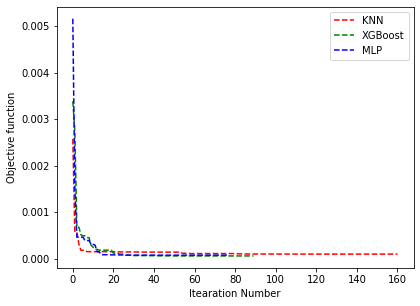

In [92]:
file_name=['./results/6 features as such 1 model/knn_obj.npy',
           './results/6 features as such 1 model/xgb_obj.npy',
           './results/6 features as such 1 model/mlp_obj.npy']
obj_vec=[]
for file in file_name:
    obj_vec.append(np.load(file))
    
import matplotlib.pyplot as plt
plt.figure(figsize=(6.4,4.8))
plt.plot(obj_vec[0],'r--',label='KNN')
plt.plot(obj_vec[1],'g--',label='XGBoost')
plt.plot(obj_vec[2],'b--',label='MLP')
plt.xlabel('Itearation Number')
plt.ylabel('Objective function')
#plt.title('loss curve')
plt.legend(loc='upper right')
plt.show()    

In [90]:
x0,x=[0.22,1.62,2.43,1.83,0.56,0.77,0.39,1.70],[0]*8

In [91]:
q=[0.99398116, 0.98014432, 0.99987871, 1.01938244]

In [92]:
for i in range(len(q)):
    x[2*i]=q[i]*x0[2*i]
    x[2*i+1]=q[i]*x0[2*i+1]

In [93]:
x

[0.21867585520000002,
 1.6102494792000002,
 2.3817506976000002,
 1.7936641056,
 0.5599320776000001,
 0.7699066067,
 0.3975591516,
 1.732950148]